# Setup the Environment

In [1]:
import os
import torch
import model
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torchsummary import summary
from IPython.display import Audio, display
from torch.utils import data
from dataloader import MtatDataset
from evaluate import Predict
from robustness import PredictNoisy

In [2]:
if not os.path.exists("./results"):
    os.makedirs("./results")

In [3]:
use_cuda = torch.cuda.is_available()
print("Using GPU..." if use_cuda else "Using CPU")

Using GPU...


# Visualize Different Augmentations

In [4]:
dataset = MtatDataset(split='TEST', input_length=59049,aug_types=(True,True,True))
data_org, _ = dataset[0]
display(Audio(data_org, rate=16000))
data_noise_aug, _ = dataset.get_augmented(0,(True,False,False))
display(Audio(data_noise_aug, rate=16000))
data_timeshift_aug, _ = dataset.get_augmented(0,(False,True,False),timeshift_rate=1.1)
display(Audio(data_timeshift_aug, rate=16000))
data_pitchshift_aug, _ = dataset.get_augmented(0,(False,False,True),pitchshift_rate=5)
display(Audio(data_pitchshift_aug, rate=16000))

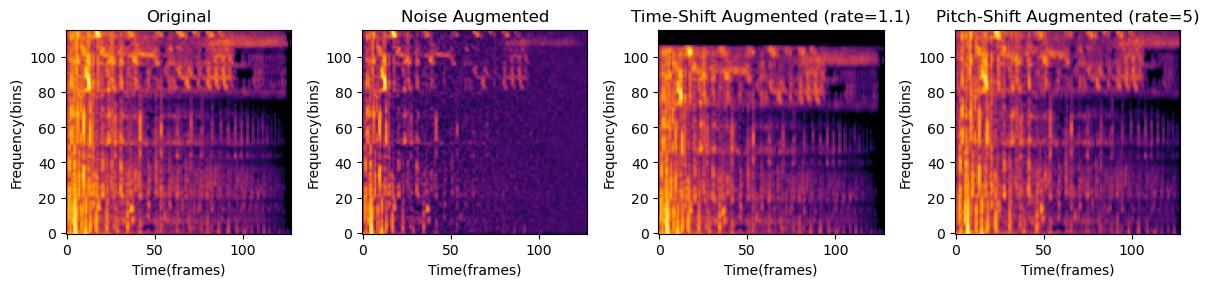

In [5]:
D_org = librosa.feature.melspectrogram(y=data_org, sr=16000, n_mels=128)
log_D_org = librosa.power_to_db(D_org, ref=np.max)

D_noise_aug = librosa.feature.melspectrogram(y=data_noise_aug, sr=16000, n_mels=128)
log_D_noise_aug = librosa.power_to_db(D_noise_aug, ref=np.max)

D_timeshift_aug = librosa.feature.melspectrogram(y=data_timeshift_aug, sr=16000, n_mels=128)
log_D_timeshift_aug = librosa.power_to_db(D_timeshift_aug, ref=np.max)

D_pitchshift_aug = librosa.feature.melspectrogram(y=data_pitchshift_aug, sr=16000, n_mels=128)
log_D_pitchshift_aug = librosa.power_to_db(D_pitchshift_aug, ref=np.max)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))
im_org = ax1.imshow(log_D_org.T, cmap='inferno', origin='lower')
ax1.set_title('Original')
ax1.set_xlabel('Time(frames)')
ax1.set_ylabel('Frequency(bins)')

im_noise_aug = ax2.imshow(log_D_noise_aug.T, cmap='inferno', origin='lower')
ax2.set_title('Noise Augmented')
ax2.set_xlabel('Time(frames)')
ax2.set_ylabel('Frequency(bins)')

im_timeshift_aug = ax3.imshow(log_D_timeshift_aug.T, cmap='inferno', origin='lower')
ax3.set_title('Time-Shift Augmented (rate=1.1)')
ax3.set_xlabel('Time(frames)')
ax3.set_ylabel('Frequency(bins)')

im_pitchshift_aug = ax4.imshow(log_D_pitchshift_aug.T, cmap='inferno', origin='lower')
ax4.set_title('Pitch-Shift Augmented (rate=5)')
ax4.set_xlabel('Time(frames)')
ax4.set_ylabel('Frequency(bins)')

plt.tight_layout()
plt.savefig("./results/mel_spectrograms.png", bbox_inches='tight')
plt.show()

# Results on the Unaugmented Test Set

In [6]:
models = ["fcn","musicnn","crnn","sample","se","short","short_res","hcnn","vit"]
aug_types = ["no_aug", "aug_0.25", "aug_0.5", "aug_0.75", "aug_1.0"]
aug_map = {
    "no_aug":0.0, 
    "aug_0.25":0.25, 
    "aug_0.5":0.5, 
    "aug_0.75":0.75, 
    "aug_1.0":1.0      
}
model_dict = {
    "fcn": model.FCN,
    "musicnn": model.Musicnn,
    "crnn": model.CRNN,
    "sample": model.SampleCNN,
    "se": model.SampleCNNSE,
    "short": model.ShortChunkCNN,
    "short_res": model.ShortChunkCNN_Res,
    "hcnn": model.HarmonicCNN,
    "vit": model.ViT
}

In [7]:

# # list to store the results
# results = []
# # loop through each model and augmentation type
# for model_name in models:
#     for aug in aug_types:
#         # load the model
#         model_path = f"./models/{model_name}{'_' + aug if aug != 'no_aug' else ''}.pth"
#         model = Predict(model_name, model_path)
#         print("Currently working on", model_path)
#         # get test scores
#         roc_auc, pr_auc, loss = model.get_test_score()
#         # add results to the list
#         results.append({
#             "Model": model_name,
#             "Augmentation": aug,
#             "ROC AUC": roc_auc,
#             "PR AUC": pr_auc,
#             "Loss": loss
#         })
# # create a dataFrame from results
# results_df = pd.DataFrame(results)
# results_df.to_csv("./results/test_scores_regular.csv", index=False)
# print(results_df)

In [8]:
# load the saved dataframe
df = pd.read_csv('./results/test_scores_regular.csv')
df['Augmentation'] = df['Augmentation'].map(aug_map)

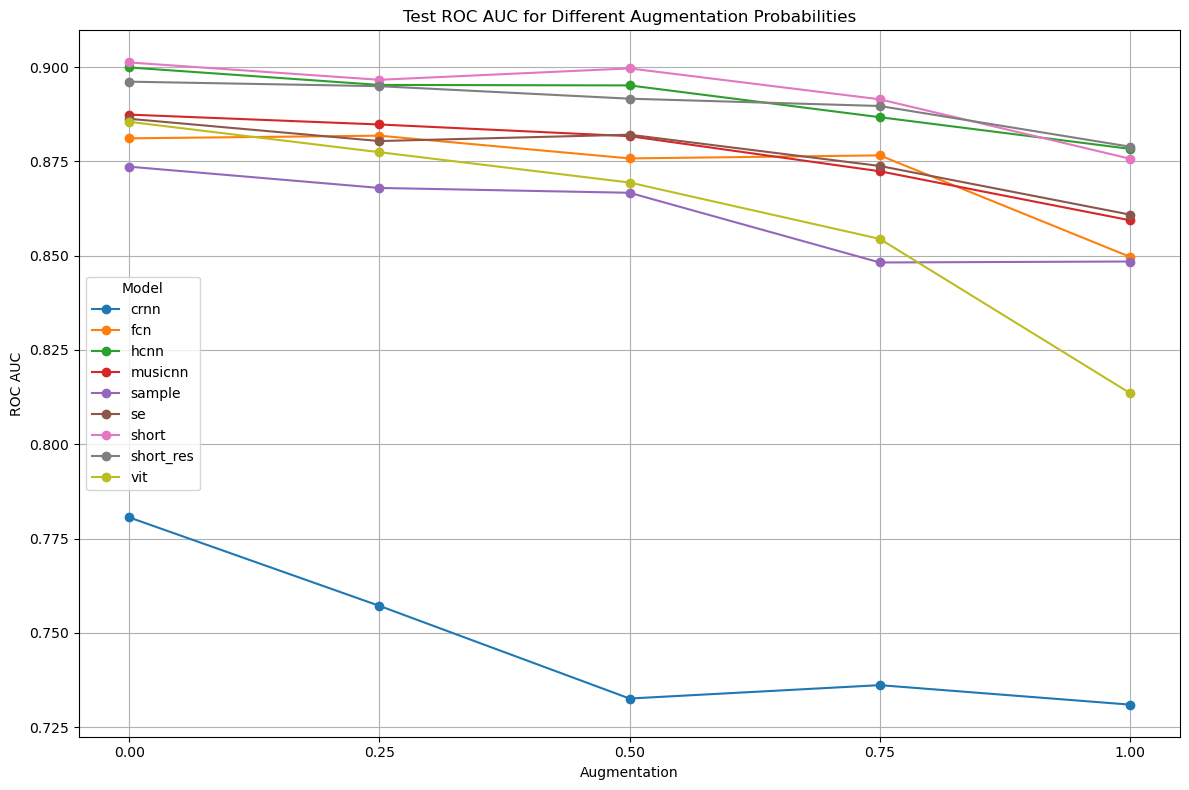

In [9]:
# plot the ROC AUC for varying augmentation probabilities
roc_df = df.pivot(index='Augmentation', columns='Model', values='ROC AUC')

plt.figure(figsize=(12, 8))
for model in roc_df.columns:
    plt.plot(roc_df.index, roc_df[model], marker='o', label=model)

plt.title('Test ROC AUC for Different Augmentation Probabilities')
plt.xlabel('Augmentation')
plt.ylabel('ROC AUC')
plt.xticks(roc_df.index)
plt.legend(title='Model')
plt.grid()
plt.tight_layout()
plt.savefig('./results/test_roc_regular.png')
plt.show()

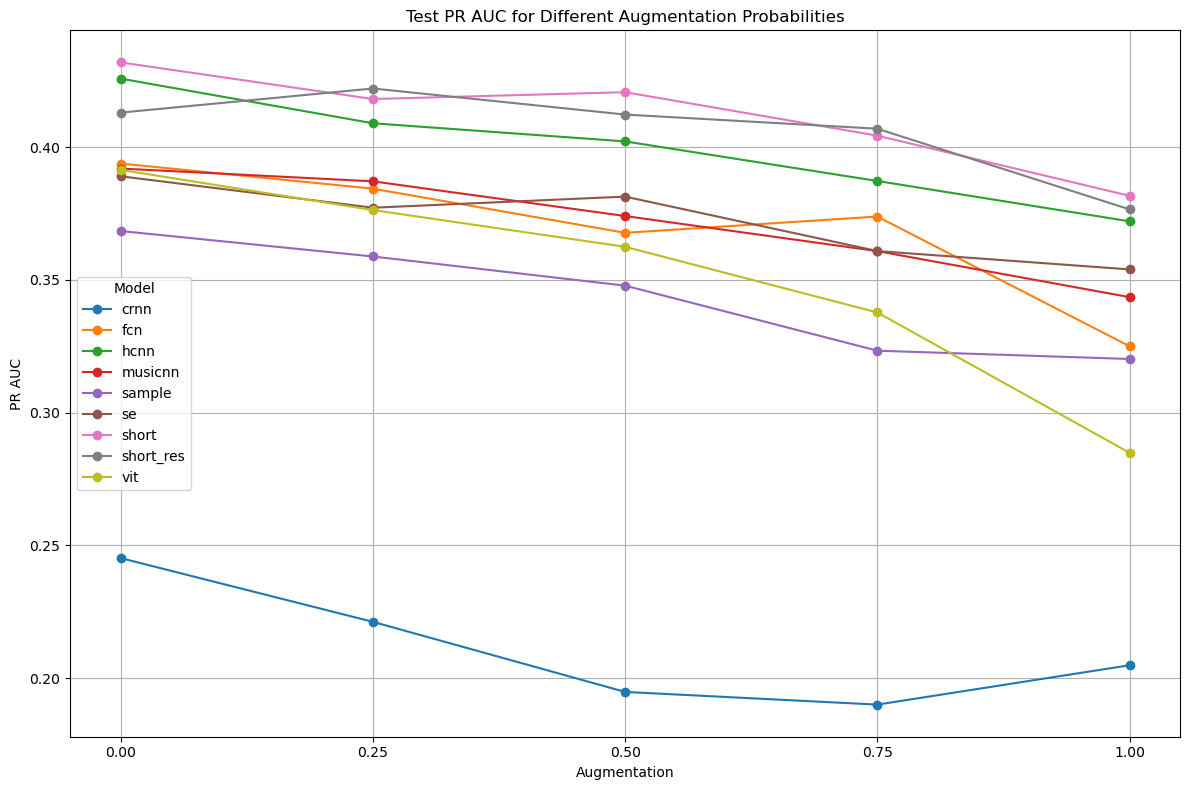

In [10]:
# plot the PR AUC for varying augmentation probabilities
pr_df = df.pivot(index='Augmentation', columns='Model', values='PR AUC')

plt.figure(figsize=(12, 8))
for model in pr_df.columns:
    plt.plot(pr_df.index, pr_df[model], marker='o', label=model)

plt.title('Test PR AUC for Different Augmentation Probabilities')
plt.xlabel('Augmentation')
plt.ylabel('PR AUC')
plt.xticks(pr_df.index)
plt.legend(title='Model')
plt.grid()
plt.tight_layout()
plt.savefig('./results/test_pr_regular.png')
plt.show()

# Results on Noisy Test Sets

The following sections will apply: 'pitch_shift'(+-1), 'time_stretch'(+-2**.5), 'noise'(0.1,0.4)

In [11]:
# models = ["short","short_res","hcnn","vit"]
# aug_types = ["no_aug","aug_0.5"]

### Pitch Shift (1)

In [12]:
# # list to store the results
# results = []
# # loop through each model and augmentation type
# for model_name in models:
#     for aug in aug_types:
#         # load the model
#         model_path = f"./models/{model_name}{'_' + aug if aug != 'no_aug' else ''}.pth"
#         model = PredictNoisy(model_name, model_path, mod='pitch_shift', rate=1)
#         print("Currently working on", model_path)
#         # get test scores
#         roc_auc, pr_auc, loss = model.get_test_score()
#         # add results to the list
#         results.append({
#             "Model": model_name,
#             "Augmentation": aug,
#             "ROC AUC": roc_auc,
#             "PR AUC": pr_auc,
#             "Loss": loss
#         })
# # create a dataFrame from results
# results_df = pd.DataFrame(results)
# results_df.to_csv("./results/test_scores_pitchshift_up.csv", index=False)
# print(results_df)

### Pitch Shift (-1)

In [13]:
# # list to store the results
# results = []
# # loop through each model and augmentation type
# for model_name in models:
#     for aug in aug_types:
#         # load the model
#         model_path = f"./models/{model_name}{'_' + aug if aug != 'no_aug' else ''}.pth"
#         model = PredictNoisy(model_name, model_path, mod='pitch_shift',rate=-1)
#         print("Currently working on", model_path)
#         # get test scores
#         roc_auc, pr_auc, loss = model.get_test_score()
#         # add results to the list
#         results.append({
#             "Model": model_name,
#             "Augmentation": aug,
#             "ROC AUC": roc_auc,
#             "PR AUC": pr_auc,
#             "Loss": loss
#         })
# # create a dataFrame from results
# results_df = pd.DataFrame(results)
# results_df.to_csv("./results/test_scores_pitchshift_down.csv", index=False)
# print(results_df)

### Time Stretch (2**0.5)

In [14]:
# # list to store the results
# results = []
# # loop through each model and augmentation type
# for model_name in models:
#     for aug in aug_types:
#         # load the model
#         model_path = f"./models/{model_name}{'_' + aug if aug != 'no_aug' else ''}.pth"
#         model = PredictNoisy(model_name, model_path, mod='time_stretch',rate=2**0.5)
#         print("Currently working on", model_path)
#         # get test scores
#         roc_auc, pr_auc, loss = model.get_test_score()
#         # add results to the list
#         results.append({
#             "Model": model_name,
#             "Augmentation": aug,
#             "ROC AUC": roc_auc,
#             "PR AUC": pr_auc,
#             "Loss": loss
#         })
# # create a dataFrame from results
# results_df = pd.DataFrame(results)
# results_df.to_csv("./results/test_scores_timestretch_up.csv", index=False)
# print(results_df)

### Time Stretch (2**-0.5)

In [15]:
# # list to store the results
# results = []
# # loop through each model and augmentation type
# for model_name in models:
#     for aug in aug_types:
#         # load the model
#         model_path = f"./models/{model_name}{'_' + aug if aug != 'no_aug' else ''}.pth"
#         model = PredictNoisy(model_name, model_path, mod='time_stretch',rate=2**-0.5)
#         print("Currently working on", model_path)
#         # get test scores
#         roc_auc, pr_auc, loss = model.get_test_score()
#         # add results to the list
#         results.append({
#             "Model": model_name,
#             "Augmentation": aug,
#             "ROC AUC": roc_auc,
#             "PR AUC": pr_auc,
#             "Loss": loss
#         })
# # create a dataFrame from results
# results_df = pd.DataFrame(results)
# results_df.to_csv("./results/test_scores_timestretch_down.csv", index=False)
# print(results_df)

### Noise (0.1)

In [16]:
# # list to store the results
# results = []
# # loop through each model and augmentation type
# for model_name in models:
#     for aug in aug_types:
#         # load the model
#         model_path = f"./models/{model_name}{'_' + aug if aug != 'no_aug' else ''}.pth"
#         model = PredictNoisy(model_name, model_path, mod='white_noise',rate=0.1)
#         print("Currently working on", model_path)
#         # get test scores
#         roc_auc, pr_auc, loss = model.get_test_score()
#         # add results to the list
#         results.append({
#             "Model": model_name,
#             "Augmentation": aug,
#             "ROC AUC": roc_auc,
#             "PR AUC": pr_auc,
#             "Loss": loss
#         })
# # create a dataFrame from results
# results_df = pd.DataFrame(results)
# results_df.to_csv("./results/test_scores_noise_0.1.csv", index=False)
# print(results_df)

### Noise (0.4)

In [17]:
# # list to store the results
# results = []
# # loop through each model and augmentation type
# for model_name in models:
#     for aug in aug_types:
#         # load the model
#         model_path = f"./models/{model_name}{'_' + aug if aug != 'no_aug' else ''}.pth"
#         model = PredictNoisy(model_name, model_path, mod='white_noise',rate=0.4)
#         print("Currently working on", model_path)
#         # get test scores
#         roc_auc, pr_auc, loss = model.get_test_score()
#         # add results to the list
#         results.append({
#             "Model": model_name,
#             "Augmentation": aug,
#             "ROC AUC": roc_auc,
#             "PR AUC": pr_auc,
#             "Loss": loss
#         })
# # create a dataFrame from results
# results_df = pd.DataFrame(results)
# results_df.to_csv("./results/test_scores_noise_0.4.csv", index=False)
# print(results_df)

### Combined Results

In [18]:
# load pitchshift (+1)
df_pitchshift_up = pd.read_csv('./results/test_scores_pitchshift_up.csv')
print(df_pitchshift_up)

       Model Augmentation   ROC AUC    PR AUC      Loss
0      short       no_aug  0.872065  0.379921  0.171226
1      short      aug_0.5  0.896113  0.412201  0.154103
2  short_res       no_aug  0.867498  0.365405  0.172527
3  short_res      aug_0.5  0.889091  0.407672  0.157226
4       hcnn       no_aug  0.869418  0.375476  0.176348
5       hcnn      aug_0.5  0.892828  0.400669  0.155461
6        vit       no_aug  0.860721  0.348537  0.166807
7        vit      aug_0.5  0.867414  0.359524  0.165337


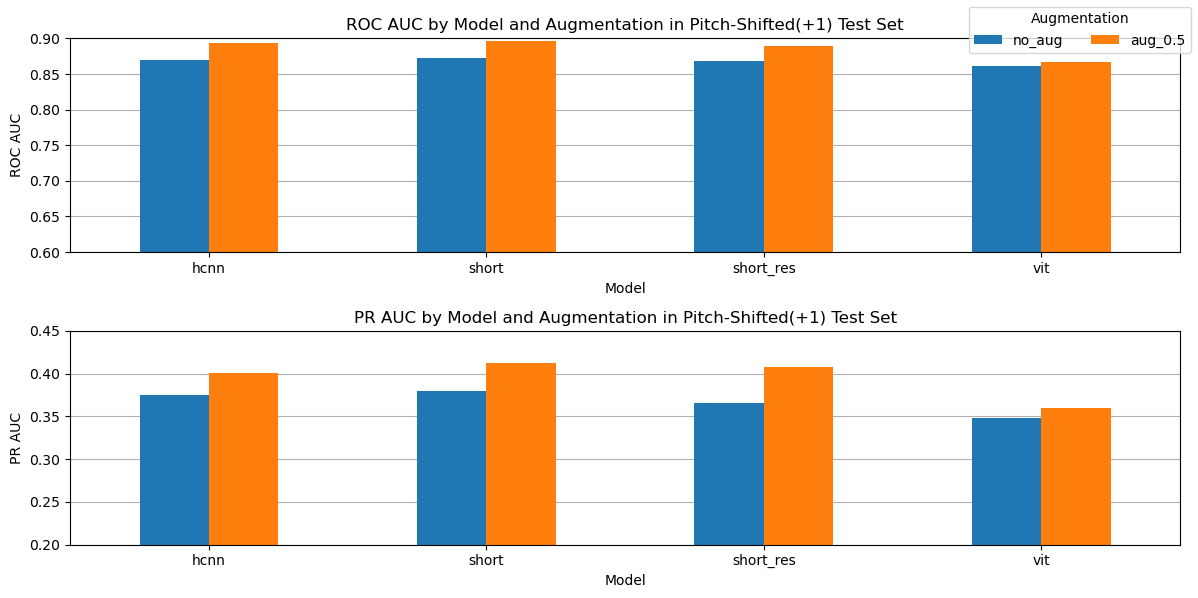

In [19]:
df_pivot_roc = df_pitchshift_up.pivot(index='Model', columns='Augmentation', values='ROC AUC')
df_pivot_pr = df_pitchshift_up.pivot(index='Model', columns='Augmentation', values='PR AUC')
df_pivot_roc = df_pivot_roc.reindex(columns=df_pivot_roc.columns[::-1])
df_pivot_pr = df_pivot_pr.reindex(columns=df_pivot_pr.columns[::-1])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# plot ROC AUC
df_pivot_roc.plot(kind='bar', ax=ax1, stacked=False)
ax1.set_title('ROC AUC by Model and Augmentation in Pitch-Shifted(+1) Test Set')
ax1.set_xlabel('Model')
ax1.set_ylabel('ROC AUC')
ax1.set_ylim(0.6,0.9)
ax1.grid(axis='y')
ax1.set_axisbelow(True)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# plot PR AUC
df_pivot_pr.plot(kind='bar', ax=ax2, stacked=False)
ax2.set_title('PR AUC by Model and Augmentation in Pitch-Shifted(+1) Test Set')
ax2.set_xlabel('Model')
ax2.set_ylabel('PR AUC')
ax2.set_ylim(0.2,0.45)
ax2.grid(axis='y')
ax2.set_axisbelow(True)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

# show global legend
ax1.get_legend().set_visible(False)
ax2.get_legend().set_visible(False)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title='Augmentation', loc='upper right', ncol=len(labels))

plt.tight_layout()
plt.savefig("./results/bar_pitchshift_up.png", bbox_inches='tight')
plt.show()

In [20]:
# load pitchshift (-1)
df_pitchshift_down = pd.read_csv('./results/test_scores_pitchshift_down.csv')
print(df_pitchshift_down)

       Model Augmentation   ROC AUC    PR AUC      Loss
0      short       no_aug  0.875202  0.374439  0.169445
1      short      aug_0.5  0.896329  0.412786  0.154501
2  short_res       no_aug  0.859727  0.340342  0.180405
3  short_res      aug_0.5  0.890346  0.407769  0.156906
4       hcnn       no_aug  0.860979  0.354095  0.177930
5       hcnn      aug_0.5  0.890350  0.395663  0.157147
6        vit       no_aug  0.839351  0.304927  0.191752
7        vit      aug_0.5  0.864095  0.351152  0.166978


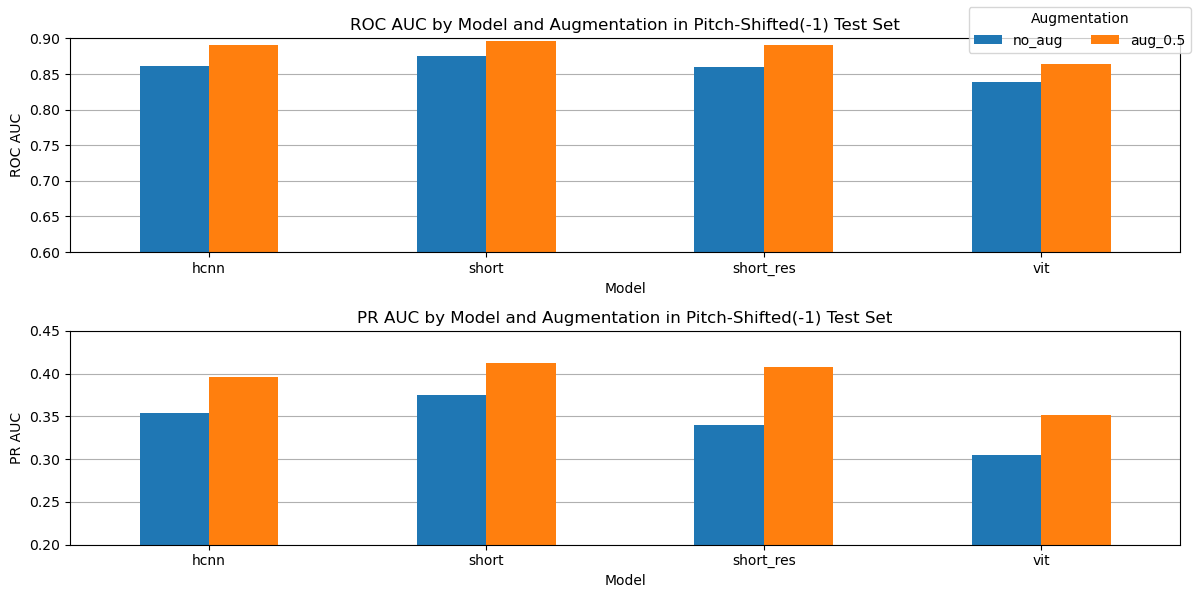

In [21]:
df_pivot_roc = df_pitchshift_down.pivot(index='Model', columns='Augmentation', values='ROC AUC')
df_pivot_pr = df_pitchshift_down.pivot(index='Model', columns='Augmentation', values='PR AUC')
df_pivot_roc = df_pivot_roc.reindex(columns=df_pivot_roc.columns[::-1])
df_pivot_pr = df_pivot_pr.reindex(columns=df_pivot_pr.columns[::-1])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# plot ROC AUC
df_pivot_roc.plot(kind='bar', ax=ax1, stacked=False)
ax1.set_title('ROC AUC by Model and Augmentation in Pitch-Shifted(-1) Test Set')
ax1.set_xlabel('Model')
ax1.set_ylabel('ROC AUC')
ax1.set_ylim(0.6,0.9)
ax1.grid(axis='y')
ax1.set_axisbelow(True)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# plot PR AUC
df_pivot_pr.plot(kind='bar', ax=ax2, stacked=False)
ax2.set_title('PR AUC by Model and Augmentation in Pitch-Shifted(-1) Test Set')
ax2.set_xlabel('Model')
ax2.set_ylabel('PR AUC')
ax2.set_ylim(0.2,0.45)
ax2.grid(axis='y')
ax2.set_axisbelow(True)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

# show global legend
ax1.get_legend().set_visible(False)
ax2.get_legend().set_visible(False)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title='Augmentation', loc='upper right', ncol=len(labels))

plt.tight_layout()
plt.savefig("./results/bar_pitchshift_down.png", bbox_inches='tight')
plt.show()

In [22]:
# load timestretch up (2**0.5)
df_timestretch_up = pd.read_csv('./results/test_scores_timestretch_up.csv')
print(df_timestretch_up)

       Model Augmentation   ROC AUC    PR AUC      Loss
0      short       no_aug  0.869796  0.379011  0.163201
1      short      aug_0.5  0.883878  0.394369  0.150999
2  short_res       no_aug  0.869108  0.371441  0.161688
3  short_res      aug_0.5  0.875733  0.384138  0.154661
4       hcnn       no_aug  0.870317  0.380987  0.164407
5       hcnn      aug_0.5  0.880847  0.382604  0.152914
6        vit       no_aug  0.881288  0.381500  0.155739
7        vit      aug_0.5  0.870793  0.363634  0.160512


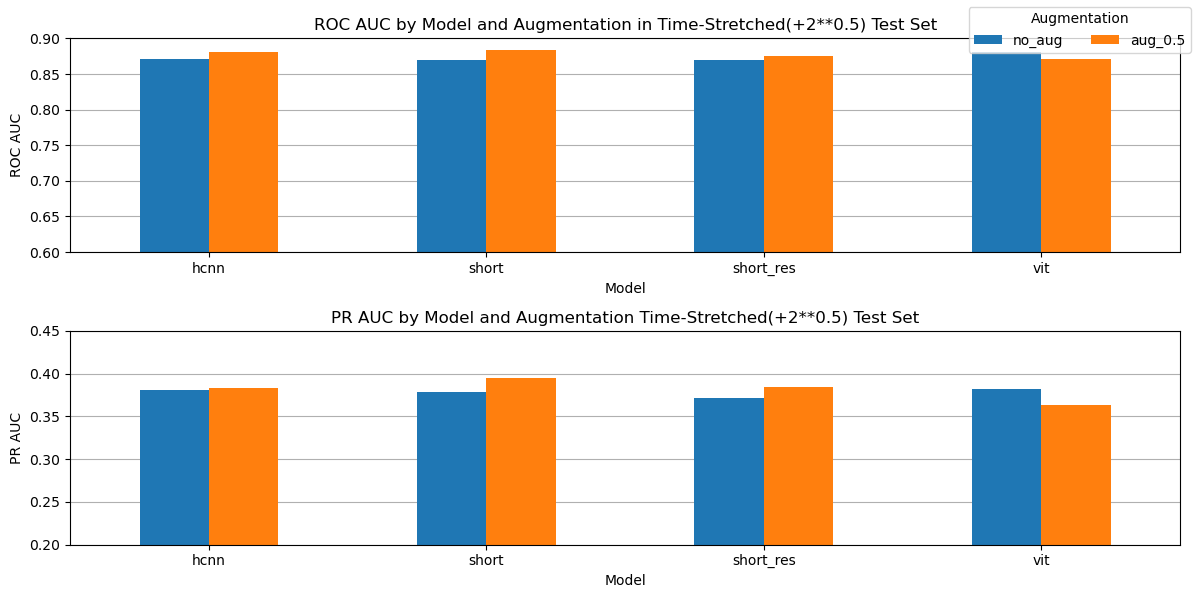

In [23]:
df_pivot_roc = df_timestretch_up.pivot(index='Model', columns='Augmentation', values='ROC AUC')
df_pivot_pr = df_timestretch_up.pivot(index='Model', columns='Augmentation', values='PR AUC')
df_pivot_roc = df_pivot_roc.reindex(columns=df_pivot_roc.columns[::-1])
df_pivot_pr = df_pivot_pr.reindex(columns=df_pivot_pr.columns[::-1])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# plot ROC AUC
df_pivot_roc.plot(kind='bar', ax=ax1, stacked=False)
ax1.set_title('ROC AUC by Model and Augmentation in Time-Stretched(+2**0.5) Test Set')
ax1.set_xlabel('Model')
ax1.set_ylabel('ROC AUC')
ax1.set_ylim(0.6,0.9)
ax1.grid(axis='y')
ax1.set_axisbelow(True)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# plot PR AUC
df_pivot_pr.plot(kind='bar', ax=ax2, stacked=False)
ax2.set_title('PR AUC by Model and Augmentation Time-Stretched(+2**0.5) Test Set')
ax2.set_xlabel('Model')
ax2.set_ylabel('PR AUC')
ax2.set_ylim(0.2,0.45)
ax2.grid(axis='y')
ax2.set_axisbelow(True)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

# show global legend
ax1.get_legend().set_visible(False)
ax2.get_legend().set_visible(False)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title='Augmentation', loc='upper right', ncol=len(labels))

plt.tight_layout()
plt.savefig("./results/bar_timestretch_up.png", bbox_inches='tight')
plt.show()

In [24]:
# load timestretch down (2**-0.5)
df_timestretch_down = pd.read_csv('./results/test_scores_timestretch_down.csv')
print(df_timestretch_down)

       Model Augmentation   ROC AUC    PR AUC      Loss
0      short       no_aug  0.850987  0.343000  0.176336
1      short      aug_0.5  0.868480  0.369759  0.158435
2  short_res       no_aug  0.847301  0.332109  0.175880
3  short_res      aug_0.5  0.860994  0.357768  0.162439
4       hcnn       no_aug  0.844058  0.339991  0.182702
5       hcnn      aug_0.5  0.868161  0.363087  0.159757
6        vit       no_aug  0.870138  0.359790  0.161634
7        vit      aug_0.5  0.865937  0.354835  0.162466


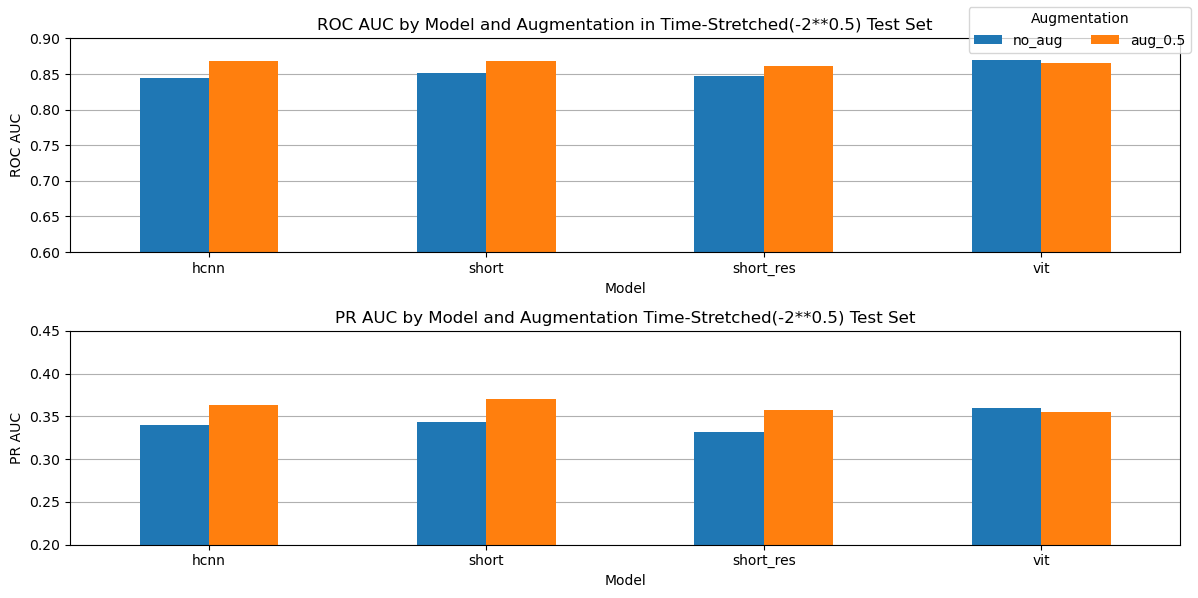

In [25]:
df_pivot_roc = df_timestretch_down.pivot(index='Model', columns='Augmentation', values='ROC AUC')
df_pivot_pr = df_timestretch_down.pivot(index='Model', columns='Augmentation', values='PR AUC')
df_pivot_roc = df_pivot_roc.reindex(columns=df_pivot_roc.columns[::-1])
df_pivot_pr = df_pivot_pr.reindex(columns=df_pivot_pr.columns[::-1])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# plot ROC AUC
df_pivot_roc.plot(kind='bar', ax=ax1, stacked=False)
ax1.set_title('ROC AUC by Model and Augmentation in Time-Stretched(-2**0.5) Test Set')
ax1.set_xlabel('Model')
ax1.set_ylabel('ROC AUC')
ax1.set_ylim(0.6,0.9)
ax1.grid(axis='y')
ax1.set_axisbelow(True)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# plot PR AUC
df_pivot_pr.plot(kind='bar', ax=ax2, stacked=False)
ax2.set_title('PR AUC by Model and Augmentation Time-Stretched(-2**0.5) Test Set')
ax2.set_xlabel('Model')
ax2.set_ylabel('PR AUC')
ax2.set_ylim(0.2,0.45)
ax2.grid(axis='y')
ax2.set_axisbelow(True)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

# show global legend
ax1.get_legend().set_visible(False)
ax2.get_legend().set_visible(False)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title='Augmentation', loc='upper right', ncol=len(labels))

plt.tight_layout()
plt.savefig("./results/bar_timestretch_down.png", bbox_inches='tight')
plt.show()

In [26]:
# load timestretch up (2**0.5)
df_noise_1 = pd.read_csv('./results/test_scores_noise_0.1.csv')
print(df_noise_1)

       Model Augmentation   ROC AUC    PR AUC      Loss
0      short       no_aug  0.869195  0.366064  0.179935
1      short      aug_0.5  0.891181  0.404812  0.159161
2  short_res       no_aug  0.828848  0.316801  0.195484
3  short_res      aug_0.5  0.884961  0.400337  0.161679
4       hcnn       no_aug  0.862490  0.364723  0.186021
5       hcnn      aug_0.5  0.885112  0.385437  0.162508
6        vit       no_aug  0.843980  0.315185  0.184644
7        vit      aug_0.5  0.856130  0.337826  0.172504


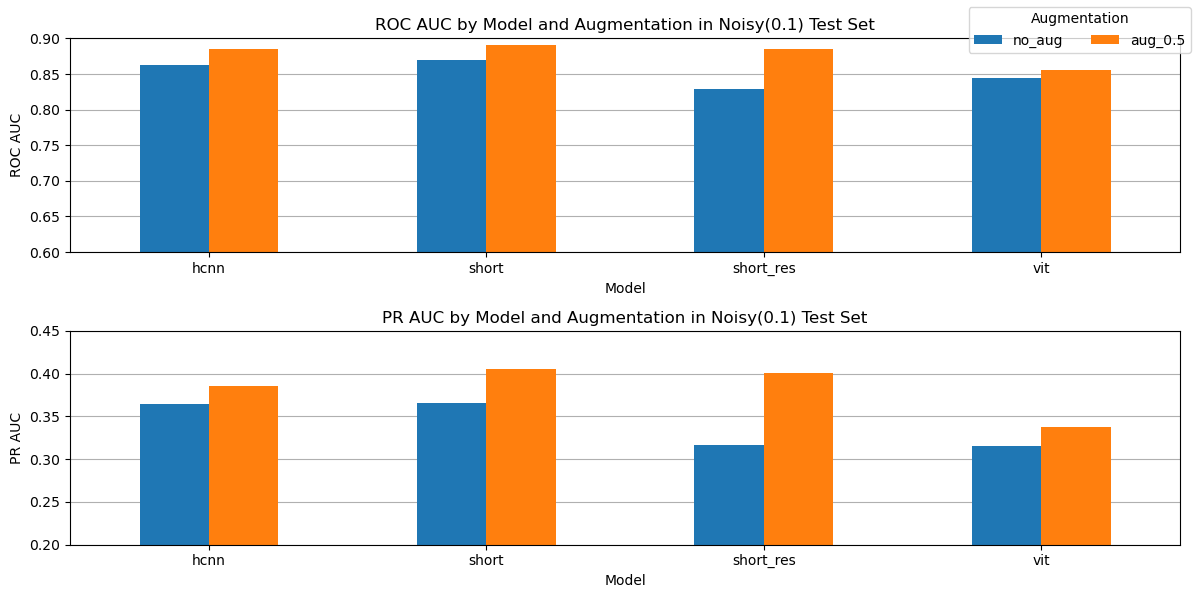

In [27]:
df_pivot_roc = df_noise_1.pivot(index='Model', columns='Augmentation', values='ROC AUC')
df_pivot_pr = df_noise_1.pivot(index='Model', columns='Augmentation', values='PR AUC')
df_pivot_roc = df_pivot_roc.reindex(columns=df_pivot_roc.columns[::-1])
df_pivot_pr = df_pivot_pr.reindex(columns=df_pivot_pr.columns[::-1])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# plot ROC AUC
df_pivot_roc.plot(kind='bar', ax=ax1, stacked=False)
ax1.set_title('ROC AUC by Model and Augmentation in Noisy(0.1) Test Set')
ax1.set_xlabel('Model')
ax1.set_ylabel('ROC AUC')
ax1.set_ylim(0.6,0.9)
ax1.grid(axis='y')
ax1.set_axisbelow(True)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# plot PR AUC
df_pivot_pr.plot(kind='bar', ax=ax2, stacked=False)
ax2.set_title('PR AUC by Model and Augmentation in Noisy(0.1) Test Set')
ax2.set_xlabel('Model')
ax2.set_ylabel('PR AUC')
ax2.set_ylim(0.2,0.45)
ax2.grid(axis='y')
ax2.set_axisbelow(True)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

# show global legend
ax1.get_legend().set_visible(False)
ax2.get_legend().set_visible(False)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title='Augmentation', loc='upper right', ncol=len(labels))

plt.tight_layout()
plt.savefig("./results/bar_noise_1.png", bbox_inches='tight')
plt.show()

In [28]:
# load timestretch up (2**0.5)
df_noise_4 = pd.read_csv('./results/test_scores_noise_0.4.csv')
print(df_noise_4)

       Model Augmentation   ROC AUC    PR AUC      Loss
0      short       no_aug  0.808989  0.272518  0.221077
1      short      aug_0.5  0.831200  0.294381  0.214385
2  short_res       no_aug  0.742956  0.209401  0.232247
3  short_res      aug_0.5  0.771841  0.224435  0.258491
4       hcnn       no_aug  0.783900  0.248942  0.228022
5       hcnn      aug_0.5  0.830090  0.292998  0.200708
6        vit       no_aug  0.767733  0.220541  0.245177
7        vit      aug_0.5  0.748915  0.205398  0.253535


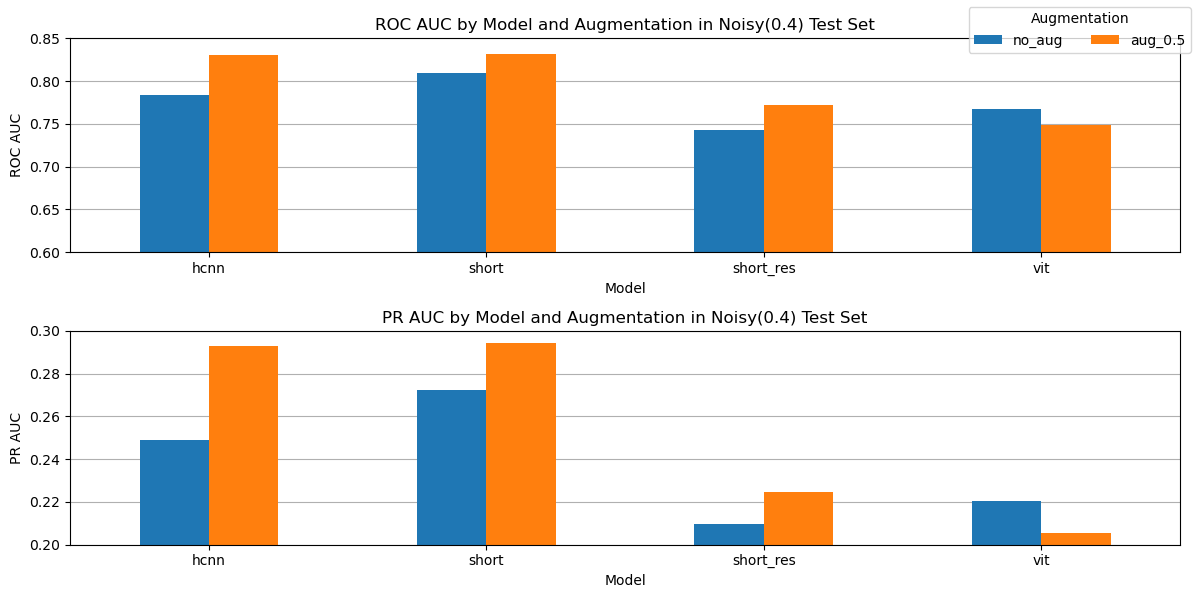

In [29]:
df_pivot_roc = df_noise_4.pivot(index='Model', columns='Augmentation', values='ROC AUC')
df_pivot_pr = df_noise_4.pivot(index='Model', columns='Augmentation', values='PR AUC')
df_pivot_roc = df_pivot_roc.reindex(columns=df_pivot_roc.columns[::-1])
df_pivot_pr = df_pivot_pr.reindex(columns=df_pivot_pr.columns[::-1])
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# plot ROC AUC
df_pivot_roc.plot(kind='bar', ax=ax1, stacked=False)
ax1.set_title('ROC AUC by Model and Augmentation in Noisy(0.4) Test Set')
ax1.set_xlabel('Model')
ax1.set_ylabel('ROC AUC')
ax1.set_ylim(0.6,0.85)
ax1.grid(axis='y')
ax1.set_axisbelow(True)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# plot PR AUC
df_pivot_pr.plot(kind='bar', ax=ax2, stacked=False)
ax2.set_title('PR AUC by Model and Augmentation in Noisy(0.4) Test Set')
ax2.set_xlabel('Model')
ax2.set_ylabel('PR AUC')
ax2.set_ylim(0.2,0.3)
ax2.grid(axis='y')
ax2.set_axisbelow(True)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)

# show global legend
ax1.get_legend().set_visible(False)
ax2.get_legend().set_visible(False)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, title='Augmentation', loc='upper right', ncol=len(labels))

plt.tight_layout()
plt.savefig("./results/bar_noise_4.png", bbox_inches='tight')
plt.show()

# Model Statistics

In [30]:
# function to get total learnable parameter given model type
def getTotalLearnableParams(model_type):
    if model_type not in models:
        print("Must be a value from the list",models)
        return -1
    a_model = model_dict[model_type]()
    return sum(par.numel() for par in a_model.parameters() if par.requires_grad)

# get total learnable parameters and store in dataframe
results = []
for m in models:
    results.append({"Model" : m, "Learnable_Parameters": getTotalLearnableParams(m)})
results_df = pd.DataFrame(results)
results_df.to_csv("./results/all_learnable_params.csv", index=False)
print(results_df)

       Model  Learnable_Parameters
0        fcn                447732
1    musicnn                784300
2       crnn                394100
3     sample               1869874
4         se               6951858
5      short               3687348
6  short_res              12104244
7       hcnn               3631551
8        vit              25066804


/home/Sadab/.conda/envs/mtat/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [31]:
# # ViT model train, validation, test scores
# vit = Predict("vit", "./models/vit.pth")
# results = [
#     {"Set": "Training"},
#     {"Set": "Validation"},
#     {"Set": "Test"}
# ]
# # add training stats
# results[0]["ROC AUC"], results[0]["PR AUC"], results[0]["Loss"] = vit.get_train_score()
# # add validation stats
# results[1]["ROC AUC"], results[1]["PR AUC"], results[1]["Loss"] = vit.get_validation_score()
# # add test stats
# results[2]["ROC AUC"], results[2]["PR AUC"], results[2]["Loss"] = vit.get_test_score()
# # save the results
# results_df = pd.DataFrame(results)
# results_df.to_csv("./results/vit_results.csv", index=False)
# print(results_df)

In [32]:
# print results of the ViT model
df = pd.read_csv('./results/vit_results.csv')
print(df)

          Set   ROC AUC    PR AUC      Loss
0    Training  0.900203  0.438528  0.152766
1  Validation  0.890656  0.399527  0.150701
2        Test  0.884683  0.390488  0.157113


In [33]:
import model
# ViT model architecture
vit = model.ViT()

model_details = []
for name, param in vit.named_parameters():
    if param.requires_grad:
        num_params = param.numel()
        dim_size = param.shape
        model_details.append((name, num_params, dim_size))

df = pd.DataFrame(model_details, columns=["Module", "# of Learnable Parameters", "Dimension"])
df.to_csv('results/vit_architecture.csv',index=False)
print(df[:5])

              Module  # of Learnable Parameters      Dimension
0  position_encoding                      16384   (1, 64, 256)
1     spec_bn.weight                          1           (1,)
2       spec_bn.bias                          1           (1,)
3       cnn.0.weight                        576  (64, 1, 3, 3)
4         cnn.0.bias                         64          (64,)


/home/Sadab/.conda/envs/mtat/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [34]:
summary(vit, input_size=(16,15*16000))

Layer (type:depth-idx)                        Param #
├─MelSpectrogram: 1-1                         --
|    └─Spectrogram: 2-1                       --
|    └─MelScale: 2-2                          --
├─AmplitudeToDB: 1-2                          --
├─BatchNorm2d: 1-3                            2
├─Sequential: 1-4                             --
|    └─Conv2d: 2-3                            640
|    └─ReLU: 2-4                              --
|    └─MaxPool2d: 2-5                         --
|    └─Conv2d: 2-6                            73,856
|    └─ReLU: 2-7                              --
|    └─MaxPool2d: 2-8                         --
|    └─Conv2d: 2-9                            295,168
|    └─ReLU: 2-10                             --
|    └─MaxPool2d: 2-11                        --
├─Conv2d: 1-5                                 16,777,472
├─TransformerEncoder: 1-6                     --
|    └─ModuleList: 2-12                       --
|    |    └─TransformerEncoderLayer: 3-1      1

Layer (type:depth-idx)                        Param #
├─MelSpectrogram: 1-1                         --
|    └─Spectrogram: 2-1                       --
|    └─MelScale: 2-2                          --
├─AmplitudeToDB: 1-2                          --
├─BatchNorm2d: 1-3                            2
├─Sequential: 1-4                             --
|    └─Conv2d: 2-3                            640
|    └─ReLU: 2-4                              --
|    └─MaxPool2d: 2-5                         --
|    └─Conv2d: 2-6                            73,856
|    └─ReLU: 2-7                              --
|    └─MaxPool2d: 2-8                         --
|    └─Conv2d: 2-9                            295,168
|    └─ReLU: 2-10                             --
|    └─MaxPool2d: 2-11                        --
├─Conv2d: 1-5                                 16,777,472
├─TransformerEncoder: 1-6                     --
|    └─ModuleList: 2-12                       --
|    |    └─TransformerEncoderLayer: 3-1      1

In [35]:
# TODO: Train ViT again and get the validation curves
# TODO: use new ViT to generate the graphs